# Variational Autoencoder with no hyperprior

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from time import time
from tqdm.notebook import tqdm, trange

import os

2023-03-04 22:29:11.857951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 22:29:11.995134: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-04 22:29:12.539646: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/data/miniconda3/envs/tf2/lib/
2023-03-04 22:29:12.539754: W tensorflow/co

## GPU settings

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

2023-03-04 22:29:18.618361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 22:29:18.619816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 22:29:18.628766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 22:29:18.630093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 22:29:18.631316: I tensorflow/compiler/xla/stream_executo

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
strategy = tf.distribute.MirroredStrategy(['/gpu:0', '/gpu:1']) # gpu distribution strategy
#strategy = tf.distribute.OneDeviceStrategy(device='/CPU:0')

2023-03-04 22:29:18.730463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 22:29:19.113567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 22:29:19.115078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 22:29:19.116446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Implementing actual model
In this chapter we try to implement the variational image compressing model of the paper on the basis of code written above.

## Encoder

In [4]:
class Encoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k, format='channel_last'):
        """Initializes the encoder."""
        
        super(Encoder, self).__init__()
        self.N      = N
        self.M      = M
        self.conv1  = tf.keras.layers.Conv2D(self.N, k, strides=2, padding='same', data_format=format)
        self.conv2  = tf.keras.layers.Conv2D(self.N, k, strides=2, data_format=format)
        self.conv3  = tf.keras.layers.Conv2D(self.N, k, strides=1, data_format=format)
        self.conv4  = tf.keras.layers.Conv2D(self.M, k, strides=1, data_format=format)
        self.gdn1   = tfc.layers.GDN()
        self.gdn2   = tfc.layers.GDN()
        self.gdn3   = tfc.layers.GDN()
    
    def call(self, inputs):
        """Forward pass of the encoder."""
        x = self.conv1(inputs)
        x = self.gdn1(x)
        x = self.conv2(x)
        x = self.gdn2(x)
        x = self.conv3(x)
        x = self.gdn3(x)
        z = self.conv4(x)
        del x
        return z

## Entropy model

In [5]:
def get_batched_emodel(batch_shape=()):
    return tfc.ContinuousBatchedEntropyModel(
        prior=tfc.distributions.NoisyDeepFactorized(batch_shape=batch_shape),
        coding_rank=1
    )


## Decoder

In [6]:
class Decoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, N, k, c, format):
        """Initializes the encoder."""
        
        super(Decoder, self).__init__()
        self.N      = N
        self.conv2  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=1, data_format=format)
        self.conv1  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=1, data_format=format)
        self.conv3  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=2, data_format=format, output_padding=(1, 1))
        self.conv4  = tf.keras.layers.Conv2DTranspose(c, k, strides=2, data_format=format, padding='same')
        self.gdn1   = tfc.layers.GDN(inverse=True)
        self.gdn2   = tfc.layers.GDN(inverse=True)
        self.gdn3   = tfc.layers.GDN(inverse=True)
    
    def call(self, inputs):
        """Forward pass of the decoder."""
        x = self.conv1(inputs)
        x = self.gdn1(x)
        x = self.conv2(x)
        x = self.gdn2(x)
        x = self.conv3(x)
        x = self.gdn3(x)
        z = self.conv4(x)
        return z

## Full model

In [7]:
class Balle(tf.keras.Model):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k1, k2, c, format):
        """Initializes the encoder."""
        
        super(Balle, self).__init__()

        self.bemodel = get_batched_emodel(())
        self.encoder = Encoder(N, M, k2, format)
        self.decoder = Decoder(N, k2, c, format)


    def call(self, inputs, training = True):

        y = self.encoder(inputs)
        y_tilde, rate_b = self.bemodel(y, training=training)

        x_tilde = self.decoder(y_tilde)

        return x_tilde, rate_b

# Functions

In [8]:
def read_data_numpy(data_path, format='channels_last'):
    """Read data from file and return a numpy array."""
    with open(data_path, 'rb') as f:
        # read data from file
        X = np.fromfile(f, dtype=np.uint8)
        # reshape data to (num_images, 3, 96, 96)
        X = np.reshape(X, (-1, 3, 96, 96))
        # transpose data to (num_images, 96, 96, 3) to match the image format
        # NOTE that tensorflow may use a different image format (e.g., channels_first: (num_images, 3, 96, 96))
        if format=='channels_last':
            return np.transpose(X, (0, 3, 2, 1))
        elif format=='channels_first':
            return np.transpose(X, (0, 1, 3, 2))
        else:
            print('unrecognized option "'+format+'"')
            return None
    

def visualize_images(images, format):
    """Visualize images in a grid of 4 rows x 4 columns."""
    # Create a list of 16 images by random sampling from the dataset first dimension without replacement
    image_list = [images[i] for i in np.random.choice(images.shape[0], 16, replace=False)]
    if format=='channels_first':
        image_list = [np.transpose(image, (1, 2, 0)) for image in image_list]
    
    # check if the images are normalized
    norm = np.max(image_list) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if norm:
            ax.imshow(image_list[i]) # no need to convert to uint8
        else:
            ax.imshow(image_list[i].astype(np.uint8)) # convert to uint8 for visualization
        ax.axis('off')

    # Show the plot
    plt.show()

# Constants

In [9]:
DATA_FOLDER = "../data/stl10/stl10_binary/"
DATA_FILE   = "unlabeled_X.bin"

TRAINING_SET_SIZE      = 80_000 # 80,000 images for training -> 20,000 images for validation
VALIDATION_SET_SIZE    = 20_000
BATCH_SIZE_PER_REPLICA = 16 # batch size per gpu replica (e.g., 64 for 1 gpu, 128 for 2 gpus, etc.)
EPOCHS                 = 50


# Code for training

### Load data

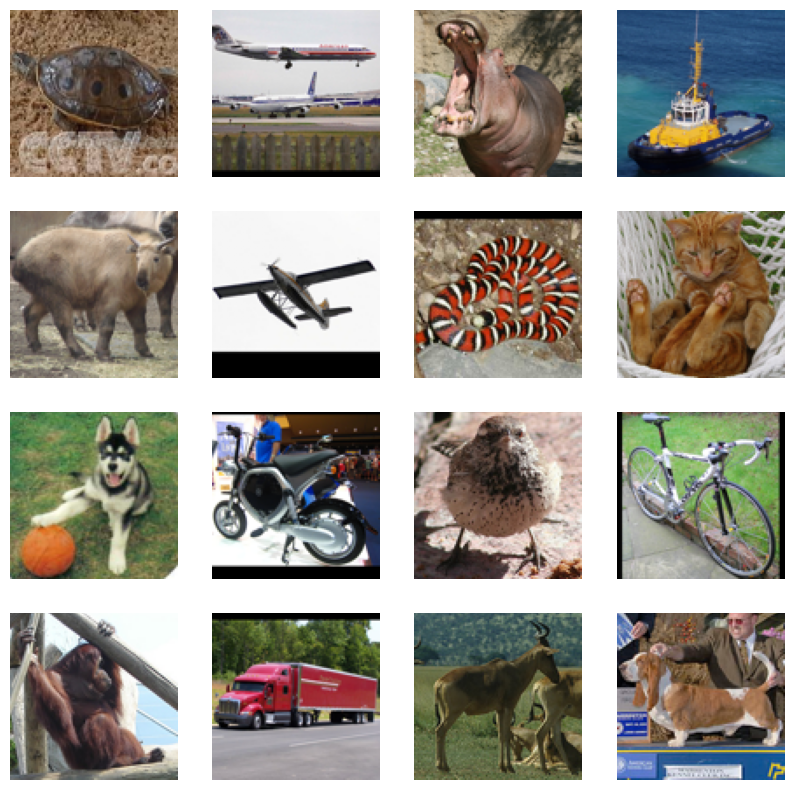

(100000, 3, 96, 96)


In [10]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
ch_format = 'channels_first'

data = read_data_numpy(data_path, ch_format)
data = data.astype('float32') / 255.0

visualize_images(data, ch_format)
print(data.shape)

### Split train and test data

In [11]:
train_images = data[:TRAINING_SET_SIZE]
test_images  = data[TRAINING_SET_SIZE:TRAINING_SET_SIZE+VALIDATION_SET_SIZE]

buffer_size       = len(train_images) # buffer size for shuffling
global_batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size (in our case 2gpu * BATCH_SIZE_PER_REPLICA)

# create train and test datasets using tf.data API

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(global_batch_size)
test_dataset  = tf.data.Dataset.from_tensor_slices(test_images).batch(global_batch_size)

In [12]:
train_dataset_dist = strategy.experimental_distribute_dataset(train_dataset)
test_dataset_dist  = strategy.experimental_distribute_dataset(test_dataset)

del train_dataset, test_dataset

2023-03-04 22:29:54.463031: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 80000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3
        }
        dim {
          size: 96
        }
        dim {
          size: 96
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT


### Create model

In [13]:
# create a VAE model using the strategy scope to distribute the model on multiple gpus
with strategy.scope():
    vae       = Balle(N=128, M=192, k1=3, k2=3, c=3, format=ch_format)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 

### Training

In [14]:
with strategy.scope():
  @tf.function
  def Loss(inputs, outputs):
    
    return tf.reduce_mean(tf.square(inputs - outputs[0])) + 0.5*(tf.reduce_mean(outputs[1]))

  @tf.function
  def compute_loss(labels, predictions):
    per_example_loss = Loss(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=global_batch_size)

In [15]:

with strategy.scope():
    @tf.function # compile the function to a graph for faster execution
    def train_step(inputs, vae):
        """Train step function."""
        with tf.GradientTape() as tape: # create a tape to record operations
            reconstructed, rateb = vae(inputs) # forward pass
            loss          = Loss(inputs, (reconstructed, rateb)) # MSE loss (maybe put this in a function)
            
        gradients = tape.gradient(loss, vae.trainable_variables) # compute gradients    
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables)) # gradient descent
        return loss # return loss for logging
    
    @tf.function
    def val_step(inputs, vae):
        outputs = vae(inputs, training=False) # forward pass
        loss    = Loss(inputs, outputs)       
        return loss 
    

def train_step_dist(inputs, vae, strategy):
    loss = strategy.run(train_step, args=(inputs, vae))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None)
    
def val_step_dist(inputs, vae, strategy):
    loss = strategy.run(val_step, args=(inputs, vae))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None)



In [17]:
for epoch in range(EPOCHS):
    total_loss = 0.0 
    num_batches = 0 
    for inputs in tqdm(train_dataset_dist, 'training steps'): 
        total_loss += train_step_dist(inputs, vae, strategy) # type: ignore # sum losses across replicas
        num_batches += 1 # count number of batches
        
    train_loss = total_loss / num_batches # compute average loss
    print('Epoch {} train loss: {}'.format(epoch, train_loss))

    total_loss = 0.0
    num_batches = 0
    for inputs in tqdm(test_dataset_dist, 'validation steps'): 
        total_loss += val_step_dist(inputs, vae, strategy) # type: ignore # sum losses across replicas
        num_batches += 1 # count number of batches
        
    test_loss = total_loss / num_batches # compute average loss
    print('Epoch {} test loss: {}'.format(epoch, test_loss))

training steps: 0it [00:00, ?it/s]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
INFO:tensorflow:batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1


2023-03-04 22:30:54.611460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-04 22:30:55.273339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-04 22:30:57.066670: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0ea8041770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-04 22:30:57.066703: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-04 22:30:57.066708: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2023-03-04 22:30:57.072194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-04 22:30:57.193934: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

KeyboardInterrupt: 